# Importing Libraries

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm_notebook

import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:
#Importing csv files
train_preprocessed_df = pd.read_csv('train_preprocessed.csv')

test_preprocessed_df = pd.read_csv('test_preprocessed.csv')


In [3]:
train_preprocessed_df["sentiment_type"] = ""

train_preprocessed_df["sentiment_score"] = ""


In [4]:
# Extract sentiment and sentiment score
for index in tqdm_notebook(range(0, len(train_preprocessed_df))):
    txt = train_preprocessed_df['sentiment'][index]
    x = re.search("([A-Z])\w+", txt)
    y = re.search('[0-9]+.+[0-9]', txt)
    train_preprocessed_df["sentiment_type"][index] = x.group()
    train_preprocessed_df["sentiment_score"][index] = y.group()


  0%|          | 0/900000 [00:00<?, ?it/s]

/var/folders/sz/qlhtygjx661flzpy8w5byj240000gn/T/ipykernel_36438/787248330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_preprocessed_df["sentiment_type"][index] = x.group()
/var/folders/sz/qlhtygjx661flzpy8w5byj240000gn/T/ipykernel_36438/787248330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_preprocessed_df["sentiment_score"][index] = y.group()


In [5]:
#Drop unrelated columns
train_preprocessed_df = train_preprocessed_df.drop(
    columns=['user_id', 'book_id', 'review_id', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_comments', 'sentiment', 'n_votes'])

train_preprocessed_df.head()


,rating,review_text,sentiment_type,sentiment_score
0,5,This is a special book. It started slow for ab...,Positive,0.9337596297264099
1,3,Recommended by Don Katz. Avail for free in Dec...,Neutral,0.706608772277832
2,3,"A fun, fast paced science fiction thriller. I ...",Positive,0.8272868990898132
3,0,Recommended reading to understand what is goin...,Neutral,0.6522879004478455
4,4,"I really enjoyed this book, and there is a lot...",Positive,0.897430419921875


In [6]:
#Convert sentiment score to float
train_preprocessed_df['sentiment_score'] = train_preprocessed_df['sentiment_score'].astype(
    float)


In [7]:
train_preprocessed_df.head()


,rating,review_text,sentiment_type,sentiment_score
0,5,This is a special book. It started slow for ab...,Positive,0.933760
1,3,Recommended by Don Katz. Avail for free in Dec...,Neutral,0.706609
2,3,"A fun, fast paced science fiction thriller. I ...",Positive,0.827287
3,0,Recommended reading to understand what is goin...,Neutral,0.652288
4,4,"I really enjoyed this book, and there is a lot...",Positive,0.897430


In [8]:
#Map to ordinal values
train_preprocessed_df['sentiment_type'] = train_preprocessed_df['sentiment_type'].map({'Positive': 3, 'Neutral': 2, 'Negative': 1})

In [43]:
#90 percentile of words in each row for sequencing
train_preprocessed_df['review_text'].str.split().str.len().quantile(0.80)

319.0

In [10]:
# Find sentiment score
train_preprocessed_df['sentiment_score'] = train_preprocessed_df['sentiment_type'] * train_preprocessed_df['sentiment_score']

# Create Tensorflow Model

In [81]:
#Train-test-split
X = train_preprocessed_df.drop(columns = ['rating'])
y = train_preprocessed_df['rating']

y= to_categorical(y)

In [82]:
X_train, X_val, y_train, y_val = train_test_split(X, y , random_state = 42, test_size = 0.2)

In [83]:
#Calculate baseline accuracy

baseline_accuracy = 0.348704**2 + 0.2942**2 + 0.20995**2 + 0.080728**2 + 0.034399**2 + 0.032018**2

print(baseline_accuracy)

0.26095257562500007


Our baseline accuracy is 26.1%. The Zero R is 34.9%. Our model will need to be above these accuracy values in order to add value.

First, we separate the text data from the numeric data.

In [84]:
review_train = X_train['review_text']
review_val = X_val['review_text']

numeric_train = X_train.drop(columns = ['review_text']).to_numpy()
numeric_val = X_val.drop(columns = ['review_text']).to_numpy()

Next, we have to tokenize our text into sequences.

In [86]:
MAX_VOCAB_SIZE = 100000
MAX_SEQUENCE_LENGTH = 319 #80% of documents are 319 words and below
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(review_train)
sequences_train = tokenizer.texts_to_sequences(review_train)
sequences_val = tokenizer.texts_to_sequences(review_val)

word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

nlp_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH, padding= 'post', truncating = 'post')
print('Shape of data train tensor:', nlp_train.shape)

T = nlp_train.shape[1]

nlp_val = pad_sequences(sequences_val, maxlen=T, padding = 'post', truncating = 'post')
print('Shape of data val tensor:', nlp_val.shape)

Found 304768 unique tokens.
Shape of data train tensor: (720000, 319)
Shape of data val tensor: (180000, 319)


In [87]:
# Choosing embedding dimensionality
D = 24


In [88]:
tf.config.set_visible_devices([], 'GPU')

In [145]:
#Creating tensorflow model
nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH, ), name = 'nlp_input')
meta_input = Input(shape = (2,), name = 'meta_input')


embedding_layer = Embedding(V+1, D)(nlp_input)
nlp_out= Bidirectional(LSTM(128, dropout = 0.2, recurrent_dropout= 0.2))(embedding_layer)

concat_layer = concatenate([nlp_out, meta_input])

hidden_layer_1 = Dense(128, activation = 'relu')(concat_layer)

output_layer = Dense(6, activation = 'softmax')(hidden_layer_1)

model = Model(inputs = [nlp_input, meta_input], outputs = output_layer)

opt = Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [146]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 319)]        0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 319, 24)      7314456     ['nlp_input[0][0]']              
                                                                                                  
 bidirectional_11 (Bidirectiona  (None, 256)         156672      ['embedding_23[0][0]']           
 l)                                                                                               
                                                                                                  
 meta_input (InputLayer)        [(None, 2)]          0           []                        

In [147]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [149]:
#Plotting training model
model_1 = model.fit([nlp_train,numeric_train], y_train, validation_data = ([nlp_val, numeric_val], y_val), batch_size = 720, epochs = 100, callbacks = [stop_early])

Epoch 1/100
1000/1000 [==============================] - 2929s 3s/step - loss: 1.2649 - accuracy: 0.4550 - val_loss: 1.1465 - val_accuracy: 0.5054
Epoch 2/100
1000/1000 [==============================] - 2904s 3s/step - loss: 1.1024 - accuracy: 0.5266 - val_loss: 1.0854 - val_accuracy: 0.5324
Epoch 3/100
1000/1000 [==============================] - 2893s 3s/step - loss: 1.0665 - accuracy: 0.5419 - val_loss: 1.0746 - val_accuracy: 0.5389
Epoch 4/100
1000/1000 [==============================] - 2886s 3s/step - loss: 1.0491 - accuracy: 0.5502 - val_loss: 1.0721 - val_accuracy: 0.5383
Epoch 5/100
1000/1000 [==============================] - 2884s 3s/step - loss: 1.0334 - accuracy: 0.5585 - val_loss: 1.0680 - val_accuracy: 0.5397
Epoch 6/100
1000/1000 [==============================] - 2887s 3s/step - loss: 1.0195 - accuracy: 0.5648 - val_loss: 1.0657 - val_accuracy: 0.5429
Epoch 7/100
1000/1000 [==============================] - 2907s 3s/step - loss: 1.0054 - accuracy: 0.5726 - val_loss: 1

In [150]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision* 100:.2f}")
    print(f"Recall: {recall * 100:.2f}")
    print(f"F1 score: {f1*100:.2f}")
    
    return metric_dict


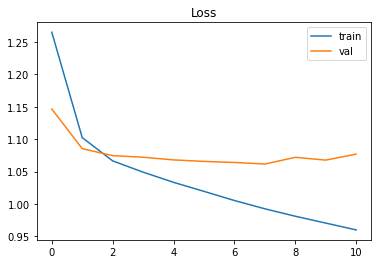

In [151]:
plt.title('Loss')
plt.plot(model_1.history['loss'], label='train')
plt.plot(model_1.history['val_loss'], label='val')
plt.legend()
plt.show();


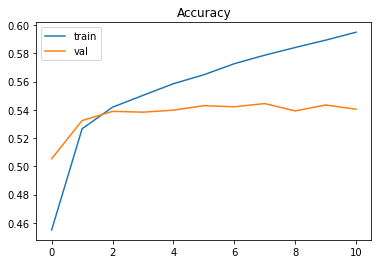

In [152]:
plt.title('Accuracy')
plt.plot(model_1.history['accuracy'], label='train')
plt.plot(model_1.history['val_accuracy'], label='val')
plt.legend()
plt.show();


In [153]:
predicted = model.predict([nlp_val, numeric_val])

In [154]:
print(predicted)

[[5.1004946e-02 1.1298710e-02 4.3444380e-02 1.8464075e-01 3.8341057e-01
  3.2620060e-01]
 [1.2708156e-03 1.4244727e-04 2.4466265e-03 7.6800302e-02 4.9668917e-01
  4.2265067e-01]
 [9.3759829e-03 3.8712742e-03 6.1243046e-02 4.4324780e-01 4.3675604e-01
  4.5505863e-02]
 ...
 [7.6350743e-01 3.0959347e-02 2.8673349e-02 4.0369917e-02 6.3175544e-02
  7.3314466e-02]
 [3.8022229e-03 1.0084298e-03 1.4388774e-02 1.8445271e-01 5.8761454e-01
  2.0873325e-01]
 [3.1136845e-03 1.4870318e-04 1.5535406e-04 7.9202210e-04 3.2344174e-02
  9.6344602e-01]]


In [155]:
#Plot classification metrics
evaluate_preds(np.argmax(y_val, axis=1), np.argmax(predicted, axis=1))


Acc: 54.04%
Precision: 0.54
Recall: 0.54
F1 score: 0.54


{'accuracy': 0.54, 'precision': 0.54, 'recall': 0.54, 'f1': 0.54}

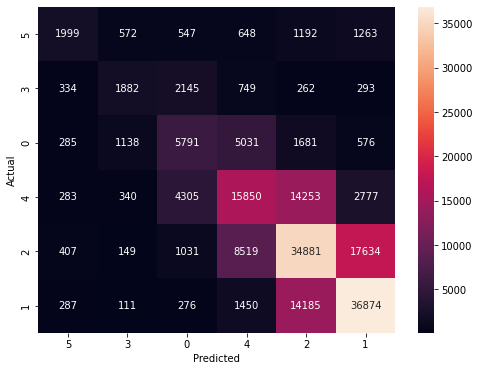

In [160]:
#Plot confusion matrix

conf_mat = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=train_preprocessed_df['rating'].unique(), yticklabels=train_preprocessed_df['rating'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [165]:
#Show classification report
print(classification_report(np.argmax(y_val, axis=1), np.argmax(predicted, axis=1)))


              precision    recall  f1-score   support

           0       0.56      0.32      0.41      6221
           1       0.45      0.33      0.38      5665
           2       0.41      0.40      0.41     14502
           3       0.49      0.42      0.45     37808
           4       0.52      0.56      0.54     62621
           5       0.62      0.69      0.65     53183

    accuracy                           0.54    180000
   macro avg       0.51      0.45      0.47    180000
weighted avg       0.54      0.54      0.54    180000



In [170]:
train_preprocessed_df['rating'].value_counts(normalize=True)

4    0.348542
5    0.294452
3    0.209969
2    0.080697
0    0.034431
1    0.031909
Name: rating, dtype: float64

In [168]:
review = X['review_text']
numeric = X.drop(columns = ['review_text']).to_numpy()

MAX_VOCAB_SIZE = 100000
MAX_SEQUENCE_LENGTH = 319 #80% of documents are 319 words and below
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(review)
sequences = tokenizer.texts_to_sequences(review)

word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

nlp = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding= 'post', truncating = 'post')
print('Shape of data train tensor:', nlp.shape)


Found 341565 unique tokens.
Shape of data train tensor: (900000, 319)


In [171]:
final_model = model.fit([nlp,numeric], y,  batch_size = 720, epochs = 8)

Epoch 1/8
1250/1250 [==============================] - 3798s 3s/step - loss: 1.1359 - accuracy: 0.5095
Epoch 2/8
1250/1250 [==============================] - 3713s 3s/step - loss: 1.0619 - accuracy: 0.5424
Epoch 3/8
1250/1250 [==============================] - 4016s 3s/step - loss: 1.0323 - accuracy: 0.5562
Epoch 4/8
1250/1250 [==============================] - 3789s 3s/step - loss: 1.0118 - accuracy: 0.5656
Epoch 5/8
1250/1250 [==============================] - 3496s 3s/step - loss: 0.9948 - accuracy: 0.5739
Epoch 6/8
1250/1250 [==============================] - 3477s 3s/step - loss: 0.9799 - accuracy: 0.5814
Epoch 7/8
1250/1250 [==============================] - 3734s 3s/step - loss: 0.9663 - accuracy: 0.5884
Epoch 8/8
1250/1250 [==============================] - 3979s 3s/step - loss: 0.9534 - accuracy: 0.5942


# Implementing on Test set

In [172]:
test_preprocessed_df["sentiment_type"] = ""

test_preprocessed_df["sentiment_score"] = ""

for index in tqdm_notebook(range(0, len(test_preprocessed_df))):
    txt = test_preprocessed_df['sentiment'][index]
    x = re.search("([A-Z])\w+", txt)
    y = re.search('[0-9]+.+[0-9]', txt)
    test_preprocessed_df["sentiment_type"][index] = x.group()
    test_preprocessed_df["sentiment_score"][index] = y.group()

test_preprocessed_df = test_preprocessed_df.drop(
    columns=['user_id', 'book_id', 'review_id', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_comments', 'sentiment', 'n_votes'])

test_preprocessed_df['sentiment_score'] = test_preprocessed_df['sentiment_score'].astype(
    float)

test_preprocessed_df['sentiment_type'] = test_preprocessed_df['sentiment_type'].map({'Positive': 3, 'Neutral': 2, 'Negative': 1})

test_preprocessed_df['sentiment_score'] = test_preprocessed_df['sentiment_type'] * test_preprocessed_df['sentiment_score']

  0%|          | 0/478033 [00:00<?, ?it/s]

/var/folders/sz/qlhtygjx661flzpy8w5byj240000gn/T/ipykernel_36438/4060403036.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_preprocessed_df["sentiment_type"][index] = x.group()
/var/folders/sz/qlhtygjx661flzpy8w5byj240000gn/T/ipykernel_36438/4060403036.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_preprocessed_df["sentiment_score"][index] = y.group()


In [174]:
review_test = test_preprocessed_df['review_text']
numeric_test = test_preprocessed_df.drop(columns = ['review_text']).to_numpy()

sequences_test = tokenizer.texts_to_sequences(review_test)

nlp_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding= 'post', truncating = 'post')
print('Shape of data train tensor:', nlp_test.shape)


Shape of data train tensor: (478033, 319)


In [175]:
final_prediction = model.predict([nlp_test,numeric_test])

In [188]:
final_prediction = np.argmax(final_prediction, axis = 1)

In [191]:
final_prediction = list(final_prediction)

# Creating the submission file

In [179]:
submission_df = pd.read_csv('test_preprocessed.csv')

submission_df = submission_df[['review_id']]

In [193]:
submission_df['rating'] = final_prediction

In [196]:
submission_df.to_csv('submission.csv', index = False)